In [192]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import IPython
import time, datetime

In [193]:
# Import CSV to Pandas
# link = "https://www.ncei.noaa.gov/access/services/data/v1?dataset=global-hourly&stations=72495723213&dataTypes=DATE,REPORT_TYPE,WND&startDate=2000-01-01&endDate="
# endDate = "2023-12-12"
# link += endDate
link ="./global-hourly-2024-01-02T20-32-28.csv"
data = pd.read_csv(link,usecols=["WND","REPORT_TYPE","DATE","TMP"],dtype={"WND": str, "REPORT_TYPE": str, "DATE": str, "TMP": str})

In [194]:
# Remove SOD and SOM reports 
data = data[~data['REPORT_TYPE'].isin(['SOD  ','SOM  '])]

In [195]:
# Split the wind data into seperate collumns
split_values = data['WND'].str.split(',', expand=True)
num_columns = len(split_values.columns)
split_values.columns = ["Direction","Direction_Quality","Type","Speed","Speed_Quality"]
data = pd.concat([data, split_values], axis=1)

In [196]:
# Drop redundant collumns
data.drop(["REPORT_TYPE","WND"],axis=1,inplace=True)

In [197]:
# Convert Speed and Direction collumns to ints
data['Direction'] = data['Direction'].astype(int)
data['Speed'] = data['Speed'].astype(int)

In [198]:
# Standardize calm and variable wind
data.loc[data['Type'] == 'C', 'Speed'] = 0
data.loc[data['Type'] == 'C', 'Direction'] = 0

In [199]:
# Remove data flagged as erroneous
data = data[data['Type'].isin(["N","C"])]
data = data[data['Direction_Quality'].isin(['0', '1', '4', '5', '9'])]# Direction quality
data = data[data['Speed_Quality'].isin(['0', '1', '4', '5', '9'])]# Speed quality

In [200]:
# Remove impossibile measurements
data = data[(data['Direction'].between(0, 360))]

In [201]:
# Remove validation collumns
data.drop(["Direction_Quality","Type","Speed_Quality"],axis=1,inplace=True)

In [202]:
#Convert Wind to Vector
windRadians = data["Direction"]*np.pi/180
data['Wx'] = data['Speed']*np.cos(windRadians)
data['Wy'] = data['Speed']*np.sin(windRadians)

In [203]:
# Remove all except Wx
data.drop(["Direction","Speed"],axis=1,inplace=True)

In [204]:
# Convert time to seconds
timestamp_s = pd.to_datetime(data['DATE']).map(pd.Timestamp.timestamp)
data['DATE'] = timestamp_s

In [205]:
# Add day-part and year-part to dataframe
day = 24*60*60
year = (365.2425)*day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [206]:
# Split temp data
split_values = data['TMP'].str.split(',', expand=True)
num_columns = len(split_values.columns)
split_values.columns = ["Temp","Quality"]
data = pd.concat([data, split_values], axis=1)

In [207]:
data['Temp'] = data['Temp'].astype(int)
data['Temp'] = data['Temp'] / 10
data = data[~data['Quality'].isin(['9'])]
data.drop(["TMP","Quality"],axis=1,inplace=True)

In [208]:
# Split data into training, validation, and testing
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_data = data[0:int(n*0.7)]
val_data = data[int(n*0.7):int(n*0.9)]
test_data = data[int(n*0.9):]

num_features = data.shape[1]
print(column_indices)

{'DATE': 0, 'Wx': 1, 'Wy': 2, 'Day sin': 3, 'Day cos': 4, 'Year sin': 5, 'Year cos': 6, 'Temp': 7}


In [209]:
# Normalize data
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

In [210]:
data.to_csv("output4.csv",index=False)

# LSTM

In [211]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_data=train_data, val_data=val_data, test_data=test_data,
               label_columns=None):
    # Store the raw data.
    self.train_data = train_data
    self.val_data = val_data
    self.test_data = test_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_data.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [212]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [213]:
def plot(self, model=None, plot_col='Wx', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [214]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [215]:
@property
def train(self):
  return self.make_dataset(self.train_data)

@property
def val(self):
  return self.make_dataset(self.val_data)

@property
def test(self):
  return self.make_dataset(self.test_data)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [216]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Wx','Wy','Temp'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Wx', 'Wy', 'Temp']

In [217]:
MAX_EPOCHS = 1

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])

In [218]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=3)
])

In [219]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 8)


Output shape: (32, 24, 3)


In [220]:
compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()

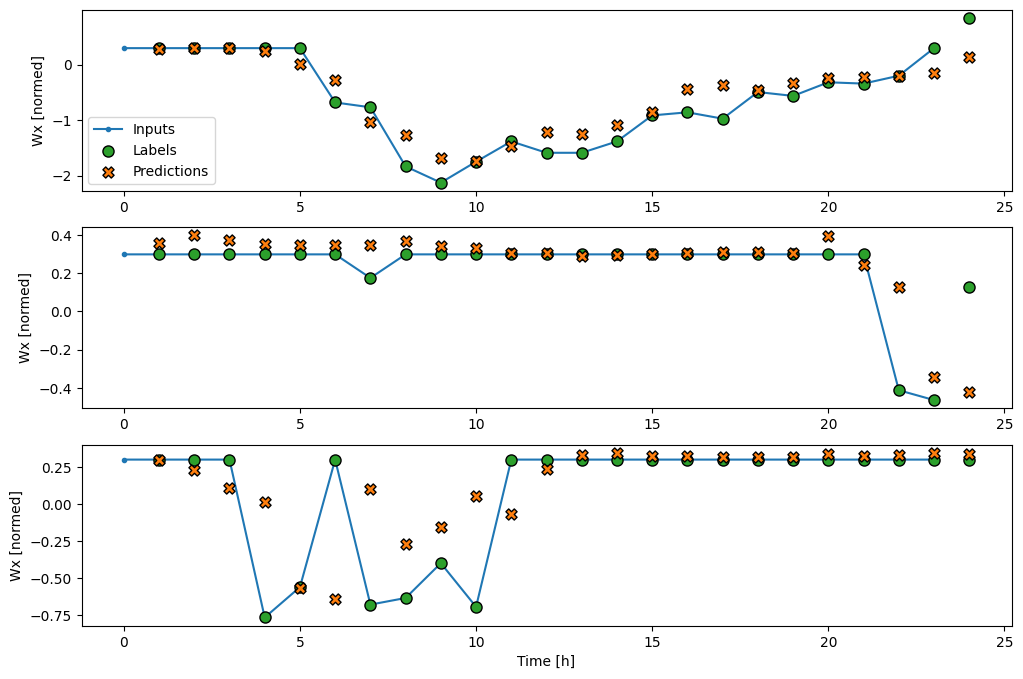

In [221]:
wide_window.plot(lstm_model,plot_col="Wx")

In [222]:
print(lstm_model(wide_window.example))

tf.Tensor(
[[[ 2.79245734e-01  4.94718552e-06 -4.92778808e-01]
  [ 3.03679079e-01  1.04063749e-03 -6.48653388e-01]
  [ 3.05659443e-01 -4.37548757e-03 -3.12919825e-01]
  ...
  [-2.06113517e-01  7.83727884e-01 -2.10655212e-01]
  [-1.45380914e-01  7.81823874e-01 -3.44902873e-01]
  [ 1.36874378e-01  3.17038327e-01 -4.00341988e-01]]

 [[ 3.56597006e-01 -7.01084733e-03 -1.09594727e+00]
  [ 3.97896856e-01 -8.46418738e-02 -1.25780976e+00]
  [ 3.73310208e-01 -1.01695657e-01 -1.19321859e+00]
  ...
  [ 1.30019993e-01  6.49813190e-02  3.36710364e-03]
  [-3.42499793e-01  1.66995689e-01  1.53735846e-01]
  [-4.22476977e-01 -2.97489196e-01  1.02352016e-01]]

 [[ 2.97370106e-01  9.52694342e-02 -4.54769641e-01]
  [ 2.25229144e-01  7.77573660e-02  2.29438916e-02]
  [ 1.06981546e-01  4.99326736e-02  4.02041942e-01]
  ...
  [ 3.26611131e-01 -5.64428419e-03 -1.15347326e+00]
  [ 3.43998075e-01  1.92507356e-03 -1.17354476e+00]
  [ 3.35705519e-01  9.36903432e-03 -1.16136706e+00]]

 ...

 [[ 3.16755772e-01 -3.1

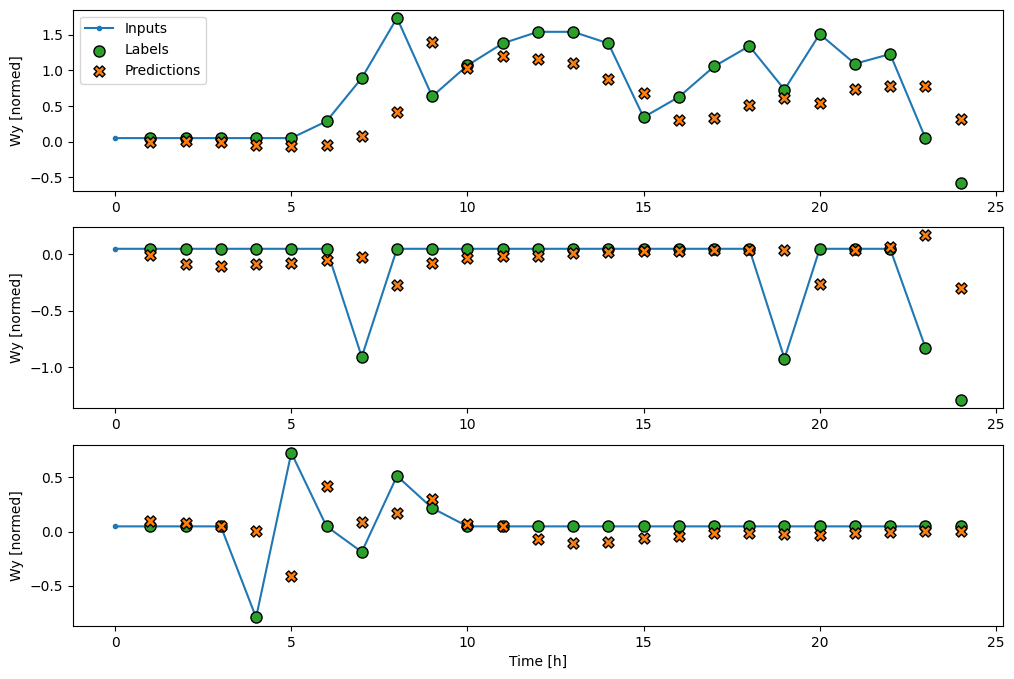

In [223]:
wide_window.plot(lstm_model,plot_col="Wy")

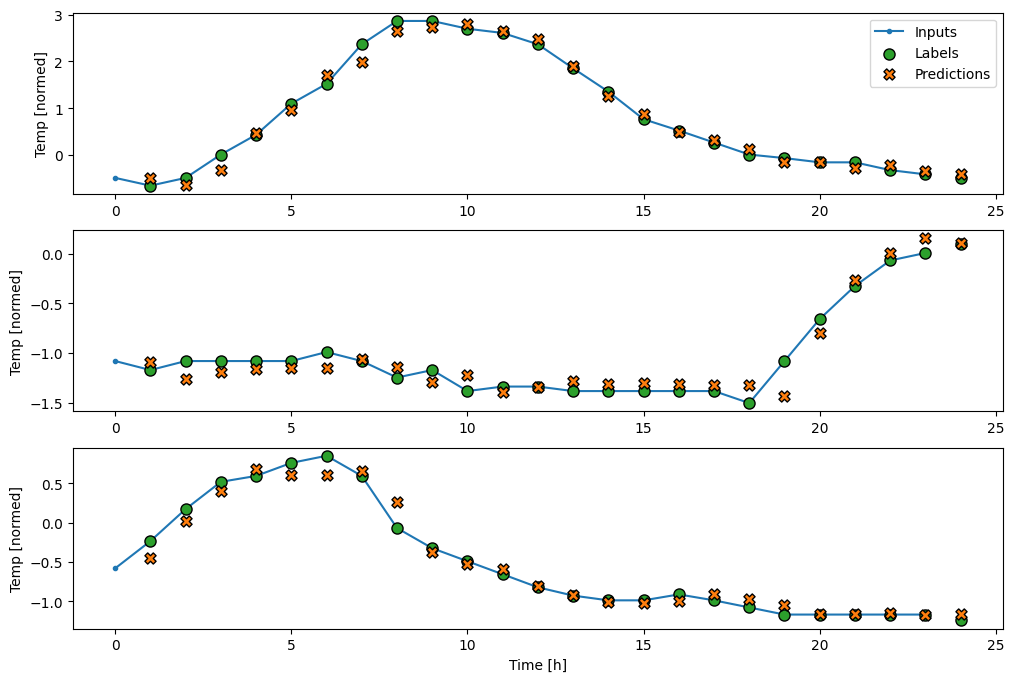

In [224]:
wide_window.plot(lstm_model,plot_col="Temp")